# Big money come -  Long - Strategy - Backtesting 

### Import Library

In [30]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [31]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [32]:
data = dataset.copy()

In [33]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [34]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


In [35]:
def prepare_data(df):
    # === Tính các trung bình volume ===
    df['vol3_avg_excl'] = df["Volume"].shift(1).rolling(3).mean()
    
    # === Điều kiện 1: Volume đột biến ===
    df['cond_1'] = df['Volume'] > 1.65 * df['vol3_avg_excl']
    
    # === Điều kiện 2: Hai nến giảm trước đó và giá giảm dần ===
    df['cond_2'] = (
        (df['Close'].shift(1) < df['Open'].shift(1)) &
        (df['Close'].shift(2) < df['Open'].shift(2)) &
        (df['Close'].shift(1) < df['Close'].shift(2))
    )

    # === Điều kiện 3: Giá hiện tại nằm cao trong vùng range 3 nến trước ===
    df['max_oc_3bars_excl'] = df[['Open', 'Close']].shift(1).rolling(3).max().iloc[:, 0]
    df['min_oc_3bars_excl'] = df[['Open', 'Close']].shift(1).rolling(3).min().iloc[:, 0]

    df['cond_3'] = (
        (df['Close'] > df['min_oc_3bars_excl'] + 0.7 * (df['max_oc_3bars_excl'] - df['min_oc_3bars_excl'])) &
        ((df['Close'] - df['Open']) > 3)
    )

    # === Tín hiệu Long ===
    df['signal'] = np.where(df['cond_1'] & df['cond_2'] & df['cond_3'], 'long', '')

    return df


In [36]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [37]:
prepared_data[prepared_data.signal == 'long']

,Open,High,Low,Close,Volume,vol3_avg_excl,cond_1,cond_2,max_oc_3bars_excl,min_oc_3bars_excl,cond_3,signal
Date,,,,,,,,,,,,
2020-11-09 14:15:00,916.8,921.3,916.7,921.0,7043,2101.666667,True,True,917.2,917.0,True,long
2020-11-17 13:15:00,920.2,923.8,920.2,923.5,3818,1761.666667,True,True,921.2,920.6,True,long
2020-11-26 14:20:00,966.1,974.9,966.1,972.2,7531,3448.666667,True,True,967.3,966.0,True,long
2021-01-07 13:00:00,1128.3,1132.2,1128.3,1132.2,2826,1491.000000,True,True,1129.7,1128.1,True,long
2021-02-17 09:35:00,1149.4,1154.4,1148.7,1154.2,3281,1901.333333,True,True,1152.6,1149.6,True,long
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 09:55:00,1854.5,1860.9,1854.1,1860.7,7498,3711.000000,True,True,1857.4,1856.6,True,long
2025-10-01 14:10:00,1864.1,1872.3,1863.8,1869.1,13372,5124.333333,True,True,1866.7,1866.0,True,long
2025-10-06 10:00:00,1886.5,1893.0,1886.5,1893.0,6485,3411.000000,True,True,1889.5,1887.9,True,long


In [38]:
class MainStrategy(Strategy):
    SL = 3.5
    RR = 3
    def init(self):
        self._broker._cash = 3500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == 'long':
            buy_price = close_price
            sl = buy_price - self.SL
            tp = buy_price + self.SL * self.RR
            self.buy(size=1, sl=sl, tp=tp)

In [39]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [40]:
stats

Start                     2020-11-02 09:15:00
End                       2025-11-04 14:45:00
Duration                   1828 days 05:30:00
Exposure Time [%]                     1.01666
Equity Final [$]                   3457.95826
Equity Peak [$]                    3535.87145
Commissions [$]                      74.04174
Return [%]                           -1.20119
Buy & Hold Return [%]               111.21745
Return (Ann.) [%]                    -0.24333
Volatility (Ann.) [%]                 0.69177
CAGR [%]                             -0.16643
Sharpe Ratio                         -0.35175
Sortino Ratio                        -0.55691
Calmar Ratio                         -0.08115
Alpha [%]                            -1.50808
Beta                                  0.00276
Max. Drawdown [%]                    -2.99849
Avg. Drawdown [%]                    -0.27996
Max. Drawdown Duration     1715 days 00:40:00
Avg. Drawdown Duration      149 days 19:48:00
# Trades                          

In [41]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,Commission,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,1,299,301,921.0,921.9,917.5,931.5,0.34713,0.55287,0.000377,2020-11-09 14:20:00,2020-11-09 14:30:00,0 days 00:10:00,None
1,1,591,604,923.3,934.0,920.0,934.0,10.14281,0.55719,0.010985,2020-11-17 13:20:00,2020-11-17 14:25:00,0 days 01:05:00,None
2,1,961,962,972.4,972.1,968.7,982.7,-0.88335,0.58335,-0.000908,2020-11-26 14:25:00,2020-11-26 14:30:00,0 days 00:05:00,None
3,1,2424,2440,1132.1,1142.7,1128.7,1142.7,9.91756,0.68244,0.008760,2021-01-07 13:05:00,2021-01-07 14:25:00,0 days 01:20:00,None
4,1,3621,3637,1154.3,1164.7,1150.7,1164.7,9.70430,0.69570,0.008407,2021-02-17 09:40:00,2021-02-17 11:00:00,0 days 01:20:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1,62181,62188,1860.7,1857.2,1857.2,1871.2,-4.61537,1.11537,-0.002480,2025-09-30 10:00:00,2025-09-30 10:35:00,0 days 00:35:00,None
89,1,62263,62263,1869.2,1865.6,1865.6,1879.6,-4.72044,1.12044,-0.002525,2025-10-01 14:15:00,2025-10-01 14:15:00,0 days 00:00:00,None
90,1,62378,62382,1893.0,1903.5,1889.5,1903.5,9.36105,1.13895,0.004945,2025-10-06 10:05:00,2025-10-06 10:25:00,0 days 00:20:00,None
91,1,63367,63368,1881.4,1892.3,1878.3,1892.3,9.76789,1.13211,0.005192,2025-11-03 10:50:00,2025-11-03 10:55:00,0 days 00:05:00,None


In [42]:
# bt.plot()

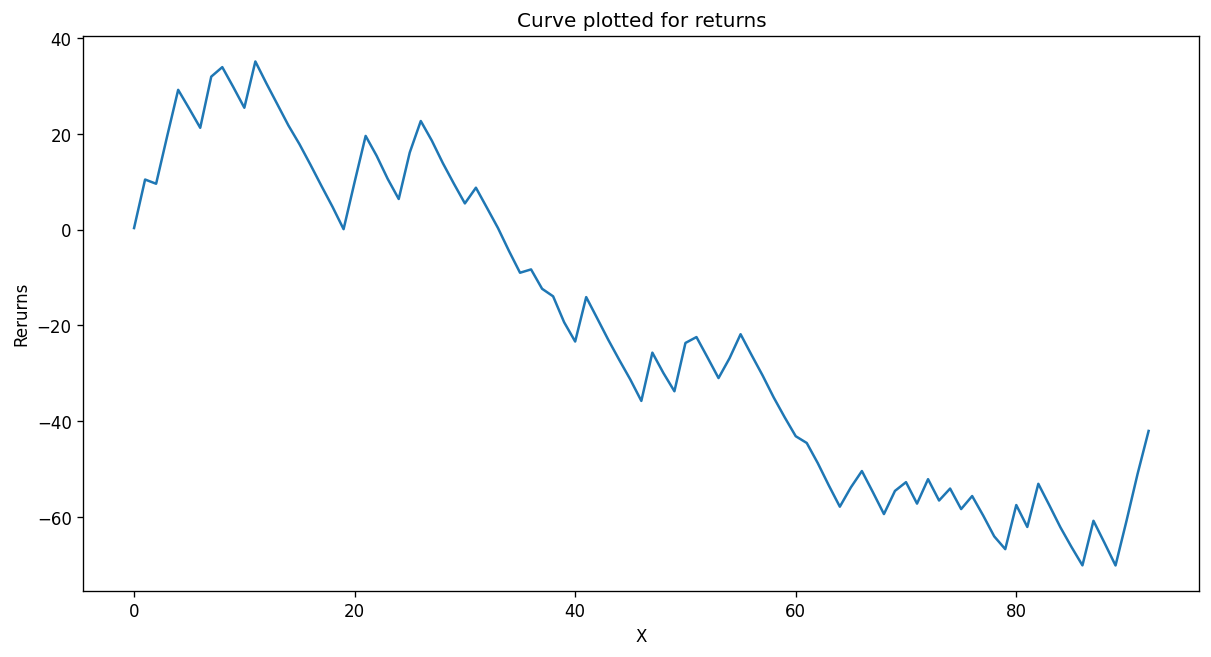

In [43]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()